## 🌟 Problem Statement
To build a complete Image Classification pipeline using Convolutional Neural Networks. The process must be divided into four stages: data loading & preprocessing, defining the architecture, training, and evaluating model performance. <p>

## ✦ Description of the Problem
Image classification tasks require learning spatial and hierarchical features present in images. CNNs are best suited for this purpose. This assignment guides the student in implementing an end-to-end image classification system starting from data preprocessing to performance estimation using accuracy, confusion matrix, and loss curves. <p>

## ✦ Program Details
- Load and preprocess images (resize, normalize, augment)<br>
- Build a custom CNN architecture<br>
- Train using suitable hyperparameters (batch size, epochs)<br>
- Evaluate on test data<br>
- Display performance metrics<br>

In [8]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

candidates = [
    "/Users/mel/Desktop/caltech-dataset",
    "/Users/mel/Desktop/cifar-dataset",
    "/Users/mel/Desktop/caltech-dataset/train",
    "/Users/mel/Desktop/cifar-dataset/train"
]

print("Ready. Candidates to check:")
for i, p in enumerate(candidates, 1):
    print(f" {i}. {p}")

Ready. Candidates to check:
 1. /Users/mel/Desktop/caltech-dataset
 2. /Users/mel/Desktop/cifar-dataset
 3. /Users/mel/Desktop/caltech-dataset/train
 4. /Users/mel/Desktop/cifar-dataset/train


In [9]:
def inspect_path(path):
    print("\nInspecting:", path)
    if os.path.exists(path):
        print(" -> Exists")
        if os.path.isdir(path):
            try:
                items = os.listdir(path)
                print(f" -> Directory contents (first 50): {len(items)} items total")
                for j, it in enumerate(items[:50], 1):
                    print(f"    {j:2d}. {it}")
            except Exception as e:
                print(" -> Couldn't list directory:", e)
        else:
            print(" -> It's a file")
    else:
        print(" -> DOES NOT EXIST")

for p in candidates:
    inspect_path(p)


Inspecting: /Users/mel/Desktop/caltech-dataset
 -> Exists
 -> Directory contents (first 50): 102 items total
     1. gerenuk
     2. hawksbill
     3. headphone
     4. ant
     5. butterfly
     6. lamp
     7. strawberry
     8. water_lilly
     9. chandelier
    10. dragonfly
    11. crab
    12. pagoda
    13. dollar_bill
    14. emu
    15. inline_skate
    16. platypus
    17. dalmatian
    18. cup
    19. airplanes
    20. joshua_tree
    21. cougar_body
    22. grand_piano
    23. trilobite
    24. brontosaurus
    25. wild_cat
    26. pigeon
    27. dolphin
    28. soccer_ball
    29. wrench
    30. scorpion
    31. flamingo_head
    32. nautilus
    33. accordion
    34. cougar_face
    35. pyramid
    36. camera
    37. barrel
    38. schooner
    39. cellphone
    40. panda
    41. revolver
    42. lobster
    43. menorah
    44. lotus
    45. stapler
    46. crocodile
    47. chair
    48. helicopter
    49. minaret
    50. starfish

Inspecting: /Users/mel/Desktop/cifar-d

In [10]:
def find_train_test(candidates_list):
    for root in candidates_list:
        if os.path.isdir(root):
            train_c = os.path.join(root, "train")
            test_c  = os.path.join(root, "test")
            if os.path.isdir(train_c) and os.path.isdir(test_c):
                return train_c, test_c
    # fallback checks
    for root in candidates_list:
        if os.path.isdir(root):
            entries = [e for e in os.listdir(root) if not e.startswith('.')]
            if any(os.path.isdir(os.path.join(root, e)) for e in entries):
                # if root ends with 'train', try sibling test
                if root.endswith("train"):
                    sibling = root[:-len("train")] + "test"
                    if os.path.isdir(sibling):
                        return root, sibling
                parent = os.path.dirname(root)
                sibling_test = os.path.join(parent, "test")
                if os.path.isdir(sibling_test):
                    return root, sibling_test
    return None, None

train_dir, test_dir = find_train_test(candidates)
if train_dir is None:
    raise FileNotFoundError(
        "Could not auto-find train/test. Check printed candidates and set `train_dir` and `test_dir` manually."
    )

print("Using:")
print(" train_dir =", train_dir)
print("  test_dir =", test_dir)

Using:
 train_dir = /Users/mel/Desktop/cifar-dataset/train
  test_dir = /Users/mel/Desktop/cifar-dataset/test


In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

print("\nClass names (train):", train_ds.class_names)
num_classes = len(train_ds.class_names)
print("Num classes:", num_classes)

Found 40079 files belonging to 10 classes.
Found 9921 files belonging to 10 classes.

Class names (train): ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Num classes: 10


In [12]:
class_names = train_ds.class_names
print("Saved class_names:", class_names)

Saved class_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)


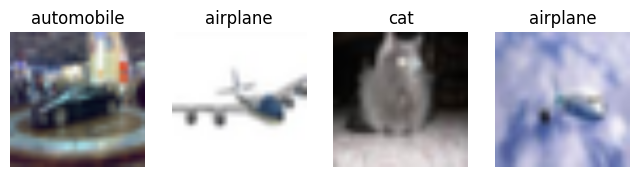

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
normalization = tf.keras.layers.Rescaling(1./255)

# IMPORTANT: class_names was saved earlier (before we modify train_ds)
# e.g. class_names = train_ds.class_names

train_ds = train_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# show shapes for one batch and plot first 4 images
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    plt.figure(figsize=(8,4))
    # labels is a tensor -> convert to numpy for indexing
    labels_np = labels.numpy()
    for i in range(min(4, images.shape[0])):
        plt.subplot(1,4,i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels_np[i])])  # use saved class_names
        plt.axis('off')
    plt.show()
    break

In [14]:
from tensorflow.keras import layers, models

# detect H,W,C
for images, labels in train_ds.take(1):
    H, W, C = images.shape[1], images.shape[2], images.shape[3]
    break

print("Detected image shape:", (H, W, C))

model = models.Sequential([
    layers.Input(shape=(H, W, C)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Detected image shape: (224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS = 5
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/5


2025-11-16 16:08:05.719589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-16 16:08:05.724754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1253/1253 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3512 - loss: 1.8008

2025-11-16 16:12:19.781239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1253/1253 ━━━━━━━━━━━━━━━━━━━━ 273s 217ms/step - accuracy: 0.3512 - loss: 1.8006 - val_accuracy: 0.5230 - val_loss: 1.3267
Epoch 2/5
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 290s 232ms/step - accuracy: 0.5533 - loss: 1.2538 - val_accuracy: 0.5581 - val_loss: 1.2419
Epoch 3/5
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 380s 303ms/step - accuracy: 0.6302 - loss: 1.0461 - val_accuracy: 0.5750 - val_loss: 1.2186
Epoch 4/5
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 394s 314ms/step - accuracy: 0.6891 - loss: 0.8840 - val_accuracy: 0.5856 - val_loss: 1.2366
Epoch 5/5
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 367s 293ms/step - accuracy: 0.7511 - loss: 0.7083 - val_accuracy: 0.5832 - val_loss: 1.3874


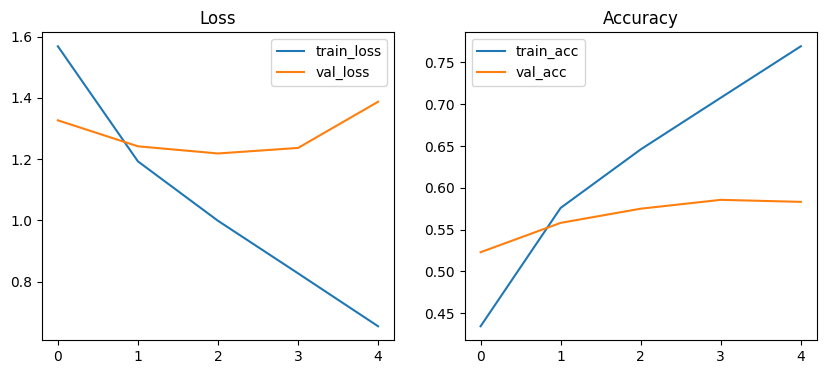

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted: airplane  -- True: airplane


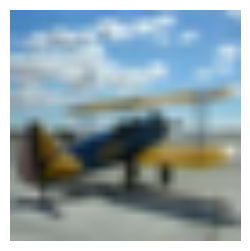

In [19]:
for images, labels in test_ds.take(1):
    sample = images[0]
    plt.figure(figsize=(3,3))
    plt.imshow(sample.numpy())
    plt.axis('off')
    pred = model.predict(sample[None, ...])
    pred_label = class_names[int(np.argmax(pred))]
    true_label = class_names[int(labels[0])]
    print("Predicted:", pred_label, " -- True:", true_label)
    break